# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.7512051157390965
 0.777095844689599
 0.39251540540108976
 0.06867788682747411
 0.05163473422497378
 0.21904912676058075
 0.000628549628893027
 0.21944650700790946
 0.6520517847741011
 0.5410686064609375
 ⋮
 0.9526123191411638
 0.17509418358658901
 0.9523198786075686
 0.8239991991536394
 0.5217138855576461
 0.794115016326136
 0.5833266962132663
 0.7886703518195843
 0.24102285044284655

In [2]:
sum(a)

4.998920238773081e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.002177 seconds (1 allocation: 16 bytes)


4.998920238773081e6

In [5]:
@time sum(a)

  0.002298 seconds (1 allocation: 16 bytes)


4.998920238773081e6

In [6]:
@time sum(a)

  0.002355 seconds (1 allocation: 16 bytes)


4.998920238773081e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [7]:
 using Pkg
 Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [8]:
using BenchmarkTools  

In [9]:
length(a)

10000000

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [10]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [11]:
c_sum(a)

4.998920238773247e6

In [13]:
abs(c_sum(a) - sum(a))

1.6577541828155518e-7

In [15]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [16]:
c_sum(a) - sum(a)  

1.6577541828155518e-7

In [17]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

We can now benchmark the C code directly from Julia:

In [18]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 528 samples with 1 evaluation.
 Range (min … max):  9.386 ms …  9.674 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.466 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.469 ms ± 43.175 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂ ▁▁▂▄▄▁▅▆▇▅▃▃▂▃▃█▄▇ ▃▄ ▄▃▄   ▁                      
  ▄▃▆▅▆▃▆█▆██████████████████▇██▆███▇▇▇█▅▃▄▇▅▄▁▆▅▄▃▃▃▃▃▃▃▃▃▃ ▅
  9.39 ms        Histogram: frequency by time        9.59 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [19]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.385667 msec


In [20]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.38567

In [21]:
using Plots
gr()

Plots.GRBackend()

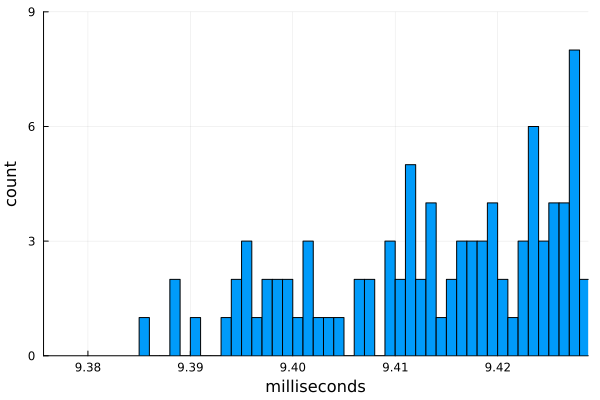

In [22]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [23]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [24]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 2730 samples with 1 evaluation.
 Range (min … max):  1.782 ms …  2.090 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.808 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.820 ms ± 37.166 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▆▁                                                        
  ▅█████▇█▇▆▆▆▅▆▅▄▄▅▄▄▄▃▄▄▄▄▄▅▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▃
  1.78 ms        Histogram: frequency by time        1.96 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [25]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.781583

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [26]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [27]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [28]:
pysum(a)

4.998920238773247e6

In [29]:
pysum(a) ≈ sum(a)

true

In [30]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  934.561 ms …    1.185 s  ┊ GC (min … max): 22.41% … 23.01%
 Time  (median):        1.161 s               ┊ GC (median):    23.46%
 Time  (mean ± σ):      1.122 s ± 105.224 ms  ┊ GC (mean ± σ):  23.17% ±  0.45%

  █                                                     ██ █  █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁█▁▁█ ▁
  935 ms           Histogram: frequency by time          1.18 s <

 Memory estimate: 152.60 MiB, allocs estimate: 10000042.

In [31]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38567
  "Python built-in" => 934.561
  "C -ffast-math"   => 1.78158

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [35]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [36]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/sergio/.julia/packages/Conda/2lg2O/src/Conda.jl:127


done
Solving environment: ...working... 

done



# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0




In [37]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

PyCall.PyError: PyError (PyImport_ImportModule

The Python package numpy could not be imported by pyimport. Usually this means
that you did not install numpy in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the numpy module, you can
use `pyimport_conda("numpy", PKG)`, where PKG is the Anaconda
package that contains the module numpy, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <class 'ImportError'>
ImportError('\n\nIMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!\n\nImporting the numpy C-extensions failed. This error can happen for\nmany reasons, often due to issues with your setup or how NumPy was\ninstalled.\n\nWe have compiled some common reasons and troubleshooting tips at:\n\n    https://numpy.org/devdocs/user/troubleshooting-importerror.html\n\nPlease note and check the following:\n\n  * The Python version is: Python3.9 from "/Users/sergio/.julia/conda/3/bin/python"\n  * The NumPy version is: "1.21.1"\n\nand make sure that they are the versions you expect.\nPlease carefully study the documentation linked above for further help.\n\nOriginal error was: dlopen(/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so, 0x0002): tried: \'/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so\' (mach-o file, but is an incompatible architecture (have \'arm64\', need \'x86_64\')), \'/System/Volumes/Preboot/Cryptexes/OS/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so\' (no such file), \'/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so\' (mach-o file, but is an incompatible architecture (have \'arm64\', need \'x86_64\'))\n')
  File "/Users/sergio/.local/lib/python3.9/site-packages/numpy/__init__.py", line 150, in <module>
    from . import core
  File "/Users/sergio/.local/lib/python3.9/site-packages/numpy/core/__init__.py", line 48, in <module>
    raise ImportError(msg)


In [34]:
numpy_sum(a)

UndefVarError: UndefVarError: `numpy_sum` not defined

In [35]:
numpy_sum(a) ≈ sum(a)

UndefVarError: UndefVarError: `numpy_sum` not defined

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 11.063
  "Python numpy"    => 6.64861
  "Python built-in" => 904.664
  "C -ffast-math"   => 6.95261

# 5. Python, hand-written 

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x174d180d0>

In [33]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.174 s …    1.419 s  ┊ GC (min … max): 18.25% … 19.33%
 Time  (median):     1.398 s               ┊ GC (median):    19.58%
 Time  (mean ± σ):   1.347 s ± 116.157 ms  ┊ GC (mean ± σ):  19.25% ±  0.66%

  █                                                   ██   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁█ ▁
  1.17 s         Histogram: frequency by time         1.42 s <

 Memory estimate: 152.60 MiB, allocs estimate: 10000042.

In [34]:
sum_py(a)

4.998920238773247e6

In [35]:
sum_py(a) ≈ sum(a)

true

In [36]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                   => 9.38567
  "Python hand-written" => 1173.66
  "Python built-in"     => 934.561
  "C -ffast-math"       => 1.78158

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [38]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:994

In [39]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 2642 samples with 1 evaluation.
 Range (min … max):  1.833 ms …  2.165 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.864 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.880 ms ± 44.980 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▃█▂                                                        
  ▄████▇▇▆▇▅▄▅▄▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  1.83 ms        Histogram: frequency by time        2.04 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [40]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38567
  "Python hand-written" => 1173.66
  "Python built-in"     => 934.561
  "Julia built-in"      => 1.8335
  "C -ffast-math"       => 1.78158

# 7. Julia (hand-written) 

In [41]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [42]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 526 samples with 1 evaluation.
 Range (min … max):  9.384 ms …  9.753 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.488 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.494 ms ± 46.322 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

               ▃▁▃▁▆▃▅█▅▁▂▅▄  ▃▂                              
  ▂▁▂▁▂▃▃▃▄▅▇███████████████████▆▆▆▆▅▄▄▆▃▃▃▂▃▃▁▁▂▂▁▂▁▂▁▂▁▁▁▃ ▄
  9.38 ms        Histogram: frequency by time        9.66 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [43]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.38567
  "Julia hand-written"  => 9.384
  "Python hand-written" => 1173.66
  "Python built-in"     => 934.561
  "Julia built-in"      => 1.8335
  "C -ffast-math"       => 1.78158

# 8. Julia (hand-written w. simd) 

In [44]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [45]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 2077 samples with 1 evaluation.
 Range (min … max):  2.360 ms …  2.620 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.385 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.394 ms ± 33.848 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █ ▁                                                        
  ▇█▇█▆▅▅▆▄▄▄▅▅▄▄▄▄▄▅▅▄▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▂▂ ▃
  2.36 ms        Histogram: frequency by time        2.52 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [46]:
mysum_simd(a)

4.998920238772938e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written simd" => 2.3595
  "C"                       => 9.38567
  "Julia hand-written"      => 9.384
  "Python hand-written"     => 1173.66
  "Python built-in"         => 934.561
  "Julia built-in"          => 1.8335
  "C -ffast-math"           => 1.78158

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.8
Julia built-in..............1.8
Julia hand-written simd.....2.4
Julia hand-written..........9.4
C...........................9.4
Python built-in...........934.6
Python hand-written......1173.7


# Tarea

    1. Implementar una aproximacion numerica de $\pi$ usando los lenguajes Julia y C. 
    2. Comparar los resultados obtenidos para igual numero de iteraciones.
    3. Evaluar los tiempos de ejecución para ambas implementaciones.

https://towardsdatascience.com/computing-pi-in-only-3-lines-95c26276f4c9

In [50]:
py"""
def py_pi(N):
    pi = 0.0
    for i in range(N):
        pi += 4 * ((-1) ** i) / (2 * i + 1)
    return pi
"""

N=1000000
pi_py = py"py_pi"
py_hand = @benchmark $pi_py($N)

BenchmarkTools.Trial: 17 samples with 1 evaluation.
 Range (min … max):  294.604 ms … 298.135 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     295.277 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   295.481 ms ± 817.418 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁    ██▁▁▁ █▁▁       ▁▁   ▁▁                                ▁  
  █▁▁▁▁█████▁███▁▁▁▁▁▁▁██▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  295 ms           Histogram: frequency by time          298 ms <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [51]:
py"""
def py_pi_mod(N):
    pi = 0.0
    for i in range(N):
        pi += 4 * (1 - (i % 2) * 2) / (2 * i + 1)
    return pi
"""

pi_py_mod = py"py_pi_mod"
py_hand = @benchmark $pi_py_mod($N)

BenchmarkTools.Trial: 36 samples with 1 evaluation.
 Range (min … max):  137.395 ms … 145.788 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     141.651 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   141.656 ms ±   1.736 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▃        █   ▃   ▃ ▃   ▃▃         ▃            
  ▇▁▁▁▁▁▁▁▇▁▁▁▁▇▇▁█▁▁▇▁▁▇▇▇█▇▇▁█▇▇▁█▁█▇▇▇██▁▇▁▁▇▇▁▁▁█▁▁▁▁▁▁▁▁▁▇ ▁
  137 ms           Histogram: frequency by time          146 ms <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [60]:
pi_py_mod(N)==pi_py(N)

true

In [52]:
C_code_pi = """
#include <stddef.h>
double c_pi(size_t n) {
    double pi = 0.0;
    for (size_t i = 0; i < n; ++i) {
        pi += 4.0 * (1.0 - (i % 2) * 2.0) / (2.0 * i + 1.0);
    }
    return pi;
}
"""

const Clib_pi = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib_pi * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code_pi) 
end

# define a Julia function that calls the C function:
c_pi(X::Int64) = ccall(("c_pi", Clib_pi), Float64, (Csize_t,), X)

c_pi (generic function with 1 method)

In [53]:
c_pi_bench = @benchmark $c_pi($N)

BenchmarkTools.Trial: 5263 samples with 1 evaluation.
 Range (min … max):  936.291 μs …  1.222 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     943.459 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   948.494 μs ± 15.320 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▁▅▂█▃▇▃▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁ ▁ ▁▁▁                              ▁
  ███████████████████████████████████▇▇▇▇▇▇▇▆▆▇▆▆▆▆▆▇▆▅▅▅▅▄▅▃▄ █
  936 μs        Histogram: log(frequency) by time         1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [54]:
const Clib_pi_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_pi_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code_pi) 
end

# define a Julia function that calls the C function:
c_pi_fastmath(X::Int64) = ccall(("c_pi", Clib_pi_fastmath), Float64, (Csize_t,), X)

c_pi_fastmath (generic function with 1 method)

In [55]:
c_pi_fastmath_bench = @benchmark $c_pi_fastmath($N)

BenchmarkTools.Trial: 6750 samples with 1 evaluation.
 Range (min … max):  730.458 μs …  1.532 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     733.541 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   739.252 μs ± 16.291 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▄▃▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁  ▁▁▁▁▁▁ ▁                             ▁
  ███████████████████████████████████▇▇▆▇▇▇▅▆▆▅▆▅▅▅▄▅▅▄▃▄▆▅▅▇▇ █
  730 μs        Histogram: log(frequency) by time       785 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [56]:
function pi_julia(N)   
    pi = 0.0 # s = zero(eltype(A))
    for i in range(0,N)
        pi += 4.0 * (1.0 - (i % 2) * 2.0) / (2.0 * i + 1.0)
    end
    return pi
end

pi_julia (generic function with 1 method)

In [57]:
j_bench_julia = @benchmark pi_julia($N)

BenchmarkTools.Trial: 5280 samples with 1 evaluation.
 Range (min … max):  936.500 μs …  1.074 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     939.334 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   945.586 μs ± 13.223 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▂▃▇▁▄▄▂▂▂▂▂▁▂▃▁▁▂▁▁ ▁▁▁ ▁▁▁▁▁                               ▁
  █████████████████████████████████▇▇▇▇▇▇▆▆▆▇▇▆▆▅▆▆▆▆▆▆▅▃▆▆▅▄▅ █
  936 μs        Histogram: log(frequency) by time       991 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [58]:
function pi_julia_simd(N)   
    pi = 0.0 # s = zero(eltype(A))
     @simd for i in range(0,N)
        pi += 4.0 * (1.0 - (i % 2) * 2.0) / (2.0 * i + 1.0)
    end
    return pi
end

pi_julia_simd (generic function with 1 method)

In [59]:
j_bench_julia_simd = @benchmark pi_julia_simd($N)

BenchmarkTools.Trial: 7937 samples with 1 evaluation.
 Range (min … max):  621.042 μs … 756.833 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     624.042 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   628.632 μs ±  11.464 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁▁▆▄ ▂▃▂▂▁▁▂▂▁▁▂▂▁ ▁▁▁▁   ▁       ▁                          ▁
  ███████████████████████████████████████▇▇▇▇▇▇▇▆▆▅▆▆▅▇▆▅▆▄▅▅▃▄ █
  621 μs        Histogram: log(frequency) by time        669 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.